### Итоговое задание по проекту №4 "Компьютер говорит "Нет"
#### Илларионов А. 

Поставлена задача построить скоринговую модель существующих клиентов банка с целью снижения вероятности выдачи кредита неблагонадёжному клиенту и снижения риска просрочки. 

Для выполнения поставленной задачи проведено исследование и очистка данных, определение значимых и независимых переменных, добавление новых признаков и создана модель, предсказывающая вероятность дефолта клиента на основе логистической регрессии.

### 1. Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from pandas import Series

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

import os
       
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


In [2]:
# Фиксируем для воспроизводимости
random_seed = 42
!pip freeze > requirements.txt

current_date = pd.to_datetime('07/12/2020')
file_dir = '/kaggle/input/sf-dst-scoring/'
pd.set_option('display.max_columns', None)

### 2. Импорт данных

In [3]:
df_train = pd.read_csv(file_dir+'train.csv')
df_test = pd.read_csv(file_dir+'test.csv')

print('df_train shape: ', df_train.shape)
print('df_test shape: ', df_test.shape)

df_train shape:  (73799, 19)
df_test shape:  (36349, 18)


Объединяем train и test в единый df, добавив исходный признак.

In [4]:
df_train['sample'] = 1
df_test['sample'] = 0
df = df_train.append(df_test, sort=False).reset_index(drop=True)

### 3. Анализ исходных данных

In [5]:
df.head(3)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [7]:
df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
sample                  0
dtype: int64

Незначительные пропуски есть только в признаке education

In [8]:
df.nunique()

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
sample                   2
dtype: int64

In [9]:
# Разделим переменные на группы
time_cols = ['app_date']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']

# client_id в список переменных не включаем

### 4. Заполнение пропусков

Сразу заполним пробелы в education, чтобы не возвращаться к этому.

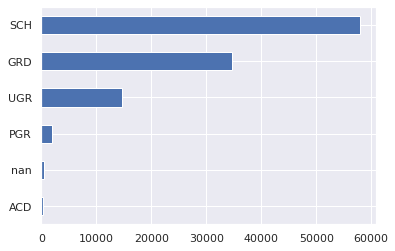

In [10]:
sns.set()
df.education.value_counts(dropna=False, ascending=True).plot.barh();

Можно было бы заполнить пропуски наиболее частым значением SCH. Однако, посмотрим, какие типы образования наиболее популярны в различных срезах.

In [11]:
# 1. - Создадим возрастные группы клиентов
print('age.min: ', df.age.min())
print('age.max: ', df.age.max())

df['age_group'] = (df.age / 10).astype('int64')
df[['age', 'age_group']].sample(2)

age.min:  21
age.max:  72


,age,age_group
100302,64,6
3336,53,5


In [12]:
# 2. - Соберём ключ для групп, внутри которых будем оценивать популярность типов образования 
df['key_ed'] = df.sex + df.age_group.map(str) + df.car + df.car_type + \
                df.good_work.map(str) + df.foreign_passport

In [13]:
# 3. - Добавим фиктивные переменные для признака education
df_edu = pd.get_dummies(df['education'], dummy_na=True, prefix='edu').astype('float64')
df = pd.concat([df, df_edu], axis=1)

In [14]:
# 4. - Вычислим средние показатели по группам key_ed

df['ACD_share'] = df.apply(lambda row: df[df.key_ed == row.key_ed].edu_ACD.mean()
                            if row.edu_nan == 1.0 else row.edu_ACD, axis=1)
df['GRD_share'] = df.apply(lambda row: df[df.key_ed == row.key_ed].edu_GRD.mean()
                            if row.edu_nan == 1.0 else row.edu_GRD, axis=1)
df['PGR_share'] = df.apply(lambda row: df[df.key_ed == row.key_ed].edu_PGR.mean()
                            if row.edu_nan == 1.0 else row.edu_PGR, axis=1)
df['SCH_share'] = df.apply(lambda row: df[df.key_ed == row.key_ed].edu_SCH.mean()
                            if row.edu_nan == 1.0 else row.edu_SCH, axis=1)
df['UGR_share'] = df.apply(lambda row: df[df.key_ed == row.key_ed].edu_UGR.mean()
                            if row.edu_nan == 1.0 else row.edu_UGR, axis=1)

In [15]:
# 5. - Определяем, у какой переменной наибольшая доля
df['max_ed_share'] = df[['ACD_share', 'GRD_share', 'PGR_share', 
                         'SCH_share', 'UGR_share']].max(axis=1)

In [16]:
# 6. - Обновление dummies с условием максимальной доли в пропусках
df['edu_ACD'] = (df['ACD_share'] == df['max_ed_share']).astype('float64')
df['edu_GRD'] = (df['GRD_share'] == df['max_ed_share']).astype('float64')
df['edu_PGR'] = (df['PGR_share'] == df['max_ed_share']).astype('float64')
df['edu_SCH'] = (df['SCH_share'] == df['max_ed_share']).astype('float64')
df['edu_UGR'] = (df['UGR_share'] == df['max_ed_share']).astype('float64')

In [17]:
# Проверка результата
df[df.max_ed_share == 0]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,age_group,key_ed,edu_ACD,edu_GRD,edu_PGR,edu_SCH,edu_UGR,edu_nan,ACD_share,GRD_share,PGR_share,SCH_share,UGR_share,max_ed_share
17276,69490,18MAR2014,NaN,F,72,Y,N,0,0,-2.362503,0,80,2,3,35000,1,1,Y,0.0,1,7,F7YN0Y,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Лишь одна запись не имеет "соседей" по группе для сравнения, поэтому на предыдущем шаге каждая dummy-переменная приравнялась к "1". Исправим вручную

In [18]:
# 7. - Оставим SCH как наиболее часто встречающееся значение
df.loc[df['max_ed_share'] == 0, ['edu_ACD', 'edu_GRD', 'edu_PGR', 'edu_UGR']] = 0

In [19]:
# 8. - # Убрать лишние столбцы и собрать новые переменные в список
df.drop(['education', 'key_ed', 'age_group', 'ACD_share', 'GRD_share', 
         'PGR_share', 'SCH_share', 'UGR_share', 'max_ed_share'], axis=1, inplace=True)

edu_list = ['edu_ACD', 'edu_GRD', 'edu_SCH', 'edu_PGR', 'edu_UGR', 'edu_nan']

In [20]:
df[(df.edu_nan == 1) & (df.edu_SCH == 0)].sample(2)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample,edu_ACD,edu_GRD,edu_PGR,edu_SCH,edu_UGR,edu_nan
79049,82831,31MAR2014,F,29,N,N,0,1,-1.891191,1,50,1,3,10000,1,4,Y,NaN,0,0.0,1.0,0.0,0.0,0.0,1.0
47453,35490,11FEB2014,M,31,Y,N,0,1,-1.932893,1,60,1,1,25000,1,4,N,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0


Таким образом, мы не просто рандомно заполнили пропуски, а подобрали наиболее подходящие фиктивные переменные для мини-срезов. Теперь необходимо обновить списки признаков. 

In [21]:
bin_cols = bin_cols + edu_list
cat_cols.remove('education')

### 5. Анализ и предобработка переменных
#### 5.1 Распределение числовых признаков

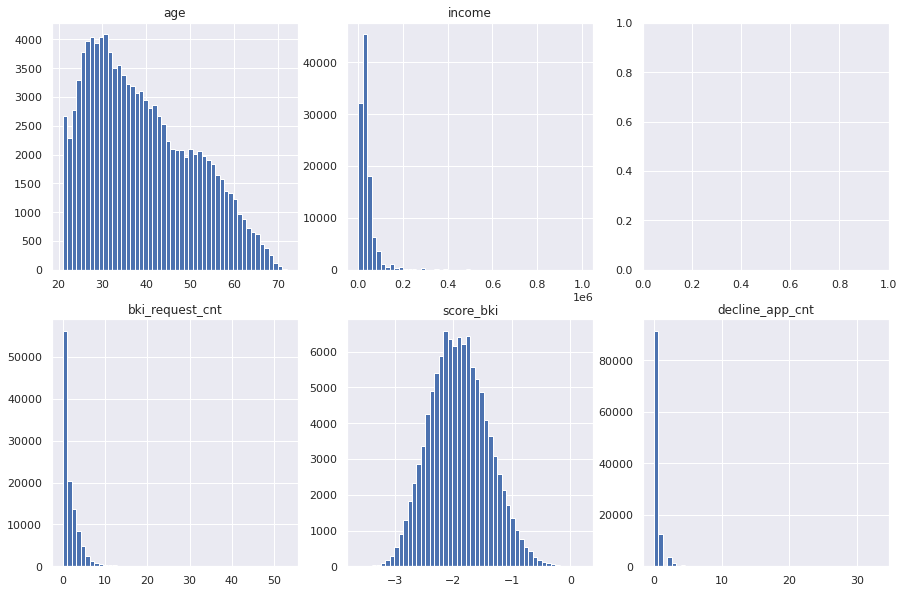

In [22]:
fig, axes = plt.subplots(2 , 3, figsize = (15,10))

axes[0][0].hist(df.age, bins = 50)
axes[0, 0].set_title('age')

axes[0][1].hist(df.income, bins = 50)
axes[0, 1].set_title('income')

axes[1][0].hist(df.bki_request_cnt, bins = 50)
axes[1, 0].set_title('bki_request_cnt')

axes[1][1].hist(df.score_bki, bins = 50)
axes[1, 1].set_title('score_bki')

axes[1][2].hist(df.decline_app_cnt, bins = 50)
axes[1, 2].set_title('decline_app_cnt');

Очевидно, что все числовые признаки, **кроме score_bki**, имеют правый хвост. Поэтому для дальнейшей обработки применим к этим признакам логарифмирование. И далее проверим наличие выбросов в переменных. 

In [23]:
for x in ['age', 'income', 'bki_request_cnt', 'decline_app_cnt']:
    df[x] = np.log(df[x]+1)

In [24]:
# Функция проверки количества выбросов
def outliers (col):
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    left_bord = round(Q1 - (1.5 * IQR), 3)
    right_bord = round(Q3 + (1.5 * IQR), 3)
    low_outs = len(df[df[col] < left_bord])
    high_outs = len(df[df[col] > right_bord])
    print(f'\nLeft border: {left_bord}', 
          f'\nRight border: {right_bord}', 
          f'\nLower Outliers number: {low_outs}', 
          f'\nUpper Outliers number: {high_outs}')

In [25]:
# Распределение признака по генеральной совокупности и Boxplot целевой переменной (train)

def get_visual(col):
    fig, axes = plt.subplots(1, 2, figsize = (10,4))
    axes[0].hist(df[col], bins = 50)
    axes[0].set_title(col)
    
    sns.boxplot(x='default', y=col, data=df[df['sample'] == 1], ax=axes[1])
    axes[1].set_title('boxplot for ' + col)
    
    plt.tight_layout()
    plt.show()
    print(f'X: {col}')
    print('Распределение целевой переменной (train): ', \
          df[df['sample'] == 1].groupby('default')[col].mean().round(3))

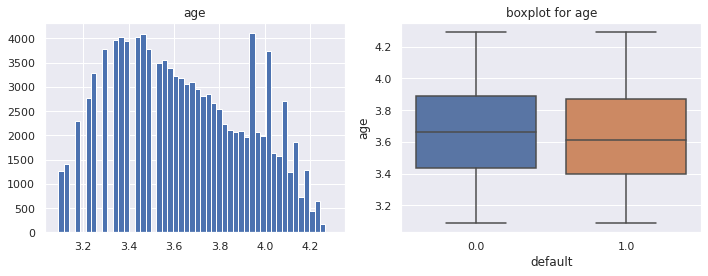

X: age
Распределение целевой переменной (train):  default
0.0    3.658
1.0    3.636
Name: age, dtype: float64

Left border: 2.747 
Right border: 4.579 
Lower Outliers number: 0 
Upper Outliers number: 0


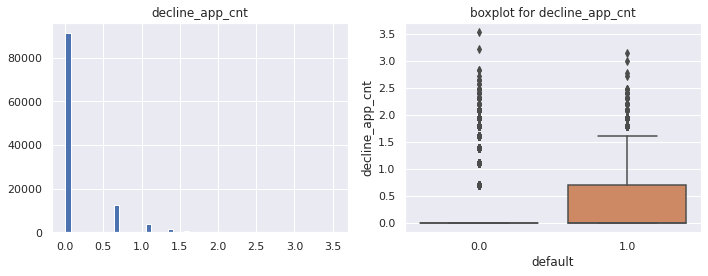

X: decline_app_cnt
Распределение целевой переменной (train):  default
0.0    0.135
1.0    0.270
Name: decline_app_cnt, dtype: float64

Left border: 0.0 
Right border: 0.0 
Lower Outliers number: 0 
Upper Outliers number: 18677


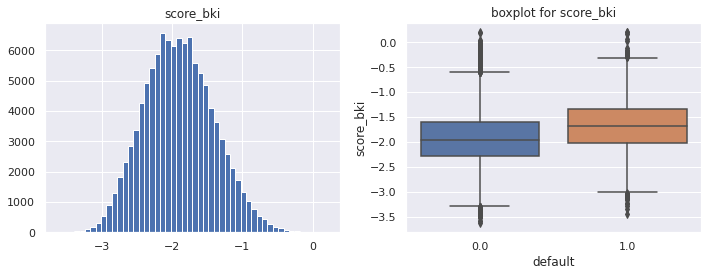

X: score_bki
Распределение целевой переменной (train):  default
0.0   -1.938
1.0   -1.676
Name: score_bki, dtype: float64

Left border: -3.299 
Right border: -0.529 
Lower Outliers number: 82 
Upper Outliers number: 436


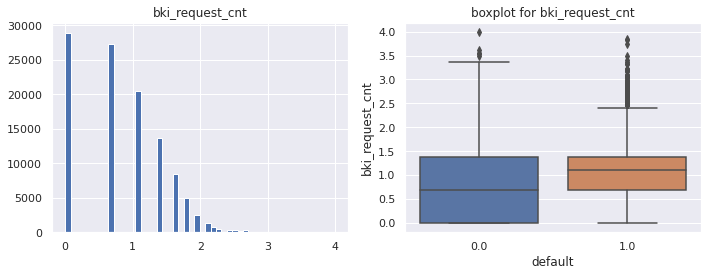

X: bki_request_cnt
Распределение целевой переменной (train):  default
0.0    0.858
1.0    1.013
Name: bki_request_cnt, dtype: float64

Left border: -2.079 
Right border: 3.466 
Lower Outliers number: 0 
Upper Outliers number: 15


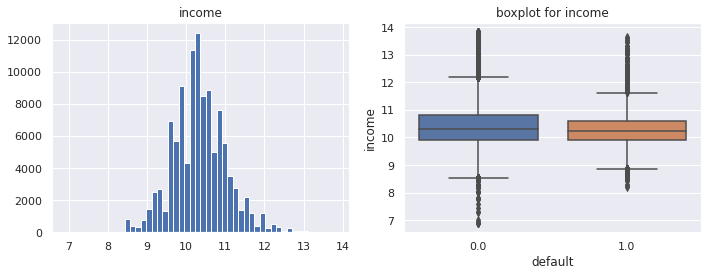

X: income
Распределение целевой переменной (train):  default
0.0    10.360
1.0    10.247
Name: income, dtype: float64

Left border: 8.59 
Right border: 12.092 
Lower Outliers number: 875 
Upper Outliers number: 1734


In [26]:
for i in num_cols:
    get_visual(i)
    outliers(i)

**Вывод**

Возраст и доход имеют логнормальное распределение, а вот decline_app_cnt и bki_request_cnt логарифмирование несильно помогло. В среднем, склонность к дефолту имеют:
* люди младшего возраста, 
* с более низким доходом, 
* с более низким по модулю скорринговым баллом БКИ
* а так же с большим числом запросов в БКИ и числом отказом (что логично)

В данных среднее количество выбросов. По возрасту они отсутствуют, а по decline_app_cnt выбросами считается абсолютно всё > 0. В доходах - выбросов в верхнюю сторону вдвое больше, чем в нижнюю. 

#### 5.2 Анализ временного ряда

In [27]:
df['app_date'] = pd.to_datetime(df.app_date, format='%d%b%Y')

# Посмотрим на первую и последнюю даты в датасете
first_date = df.app_date.min()
last_date = df.app_date.max()
print(first_date)
print(last_date)

2014-01-01 00:00:00
2014-04-30 00:00:00


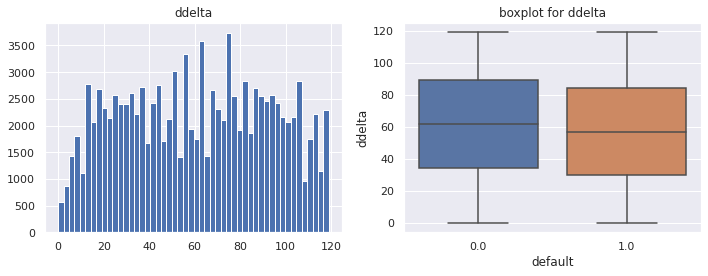

X: ddelta
Распределение целевой переменной (train):  default
0.0    61.518
1.0    57.719
Name: ddelta, dtype: float64


In [28]:
# Вводим новый признак - номер дня с 1 января и смотрим на распределение
df['ddelta'] = (df.app_date - first_date).dt.days.astype('int')
get_visual('ddelta')

Количество заявок не очень равномерно - распределение кажется бимодальным. Выбросов нет. В среднем, дефолтники подавали свои заявки ближе к началу года. Проверим это через помесячную разбивку. 

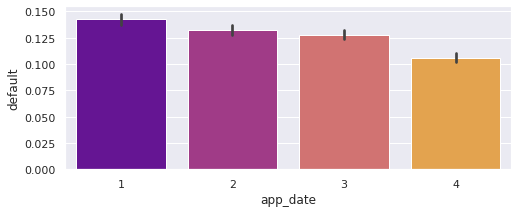

In [29]:
plt.subplots(figsize=(8, 3))
sns.barplot(data=df, x=df[df['sample'] == 1]['app_date'].dt.month, \
            y='default', palette="plasma");

Число дефолтов действительно снижается со временем

In [30]:
# Добавим новый признак в список числовых переменных
num_cols.append('ddelta')

#### 5.3 Анализ и обработка бинарных переменных

In [31]:
# Преобразуем 'Y' и 'N' в числовой формат

label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])

In [32]:
print('Распределение целевой переменной: ')
for col in bin_cols:
    print(f'\nпо признаку {col}')
    print(df[df['sample'] == 1].groupby('default')[col].mean().round(3))

Распределение целевой переменной: 

по признаку sex
default
0.0    0.433
1.0    0.462
Name: sex, dtype: float64

по признаку car
default
0.0    0.332
1.0    0.272
Name: car, dtype: float64

по признаку car_type
default
0.0    0.198
1.0    0.131
Name: car_type, dtype: float64

по признаку good_work
default
0.0    0.171
1.0    0.123
Name: good_work, dtype: float64

по признаку foreign_passport
default
0.0    0.159
1.0    0.087
Name: foreign_passport, dtype: float64

по признаку edu_ACD
default
0.0    0.003
1.0    0.001
Name: edu_ACD, dtype: float64

по признаку edu_GRD
default
0.0    0.331
1.0    0.225
Name: edu_GRD, dtype: float64

по признаку edu_SCH
default
0.0    0.516
1.0    0.628
Name: edu_SCH, dtype: float64

по признаку edu_PGR
default
0.0    0.018
1.0    0.009
Name: edu_PGR, dtype: float64

по признаку edu_UGR
default
0.0    0.132
1.0    0.138
Name: edu_UGR, dtype: float64

по признаку edu_nan
default
0.0    0.004
1.0    0.004
Name: edu_nan, dtype: float64


Из того, что сильно бросилось в глаза - наличие загранпаспорта почти двукратно снижает шансы дефолта. Так же при наличии образования GRD, вероятность дефолта заёмщика ниже. 

#### 5.4 Анализ категориальных переменных

Так как education мы уже заменили на dummies, то кодировать оставшиеся категориальные переменные не придётся.

In [33]:
print('Распределение целевой переменной: ')
for col in cat_cols:
    print(f'\nпо признаку {col}')
    print(df[df['sample'] == 1].groupby('default')[col].mean().round(3))

Распределение целевой переменной: 

по признаку region_rating
default
0.0    57.169
1.0    53.678
Name: region_rating, dtype: float64

по признаку home_address
default
0.0    1.558
1.0    1.693
Name: home_address, dtype: float64

по признаку work_address
default
0.0    2.475
1.0    2.644
Name: work_address, dtype: float64

по признаку sna
default
0.0    1.679
1.0    2.104
Name: sna, dtype: float64

по признаку first_time
default
0.0    2.806
1.0    2.486
Name: first_time, dtype: float64


Наиболее заметное отличие - повышенный риск дефолта для более высоких значений sna

### 6. Оценка значимости переменных

#### 6.1 Значимость непрерывных переменных

С помощью f_classif

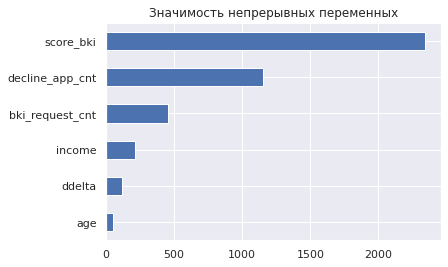

In [34]:
df_tr = df[df['sample'] == 1] # часть датасета, содержащая значения default

imp_num = pd.Series(f_classif(df_tr[num_cols], df_tr['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных');

Возраст заёмщика слабо влияет на его благонадёжность. А вот оценка БКИ очень значима. 

#### 6.2 Значимость бинарных переменных

С помощью mutual_info_classif

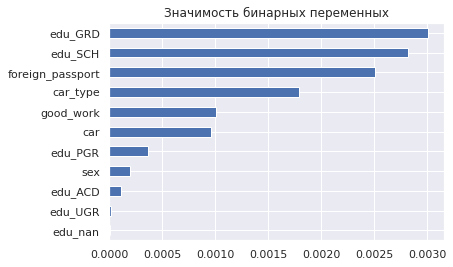

In [35]:
imp_bin = Series(mutual_info_classif(df_tr[bin_cols], 
                                     df_tr['default'], 
                                     discrete_features=True),
                 index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh', title='Значимость бинарных переменных');

Как и было замечено ранее, GRD и загранпаспорт очень значимы. SCH - тоже, однако встречается у абсолютного большинства заёмщиков. А вот edu_UGR и edu_na - имеют наименьшее значение. 

Car_type - значимее, чем Car (будем учтено при оценке коррелиции)

#### 6.3 Значимость категориальных переменных

С помощью mutual_info_classif

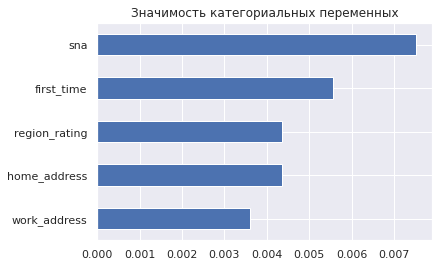

In [36]:
imp_cat = Series(mutual_info_classif(df_tr[cat_cols], 
                                     df_tr['default'], 
                                     discrete_features=True),
                 index = cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh', title='Значимость категориальных переменных');

Самым значимым признаком по Mutual information тесту является связь заемщика с клиентами банка (sna) и давность наличия информации о заемщике (first_time). Из двух представленных адресов более значим домашний - будет так же учтено при оценке корреляций.

### 7. Корреляция всех признаков

Проверим значения корреляции Пирсона для признаков и составим список самых значимых признаков для модели

In [37]:
# На 2-3-4-5 шагах проверки убираем наиболее коррелирующие переменные

x_cat_cols = cat_cols.copy()
x_cat_cols.remove('work_address') # домашний адрес значимее рабочего
x_cat_cols.remove('first_time') # менее значим, чем sna

x_bin_cols = bin_cols.copy()
x_bin_cols.remove('edu_SCH')  # SCH есть почти у всех и массово коррелирует с другими признаками
x_bin_cols.remove('car') # как выяснили ранее, car_type более значим
x_bin_cols.remove('edu_UGR') # значимость низкая, а корреляция относительно высокая

x_num_cols = num_cols.copy()
x_num_cols.remove('income') # массово коррелирует с другими признаками, да и не так значим

In [38]:
# Текущий список значимых для модели и некоррелирующих переменных
x_list = x_num_cols + x_cat_cols + x_bin_cols

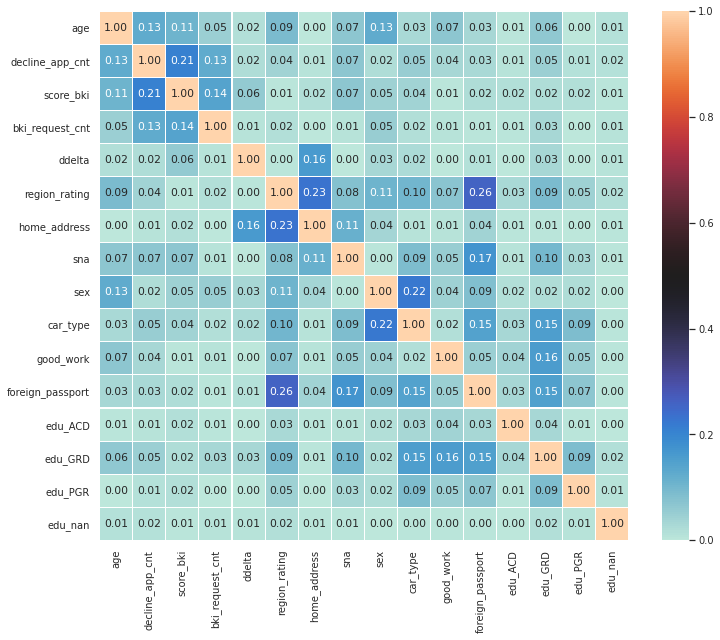

In [39]:
corr = df[x_list].corr()

sns.set(font_scale=0.9)
plt.subplots(figsize=(10, 8))
plt.tight_layout()
sns.heatmap(corr.abs(), square=True, vmin=0, vmax=1,
            annot=True, fmt=".2f", linewidths=0.1, cmap="icefire");

### 8. Подготовка признаков

#### 8.1 Создадим функцию обработки всех отобранных ранее переменных

In [40]:
def x_processing (data, cat_cols, bin_cols, num_cols):
    
    # 1 - Обработка категориальных с помощью One Hot Encoder
    OHE = OneHotEncoder(sparse = False)
    X_cat = OHE.fit_transform(data[cat_cols].values)
    
    # 2 - Стандартизация числовых переменных
    X_num = StandardScaler().fit_transform(data[num_cols].values)
    
    # 3 - Объединение обработанных данных + бинарные переменные
    X = np.hstack([X_num, X_cat, data[bin_cols].values])
    
    # 4 - Выделение вектора целевых значений
    Y = data['default'].values  
    
    return X, Y, [num_cols + OHE.get_feature_names(cat_cols).tolist() + bin_cols][0]

#### 8.2 Разделение датасета обратно на train и test

In [58]:
train_df = df.query('sample == 1').drop(['sample'], axis=1)
test_df = df.query('sample == 0').drop(['sample'], axis=1)

#### 8.3 Обработка отобранных переменных в train_df и разбивка на обучающую и валидационную части

In [59]:
X, y, x_names = x_processing(train_df, x_cat_cols, x_bin_cols, x_num_cols)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 9. Создание и обучение модели

#### Используем модель на основе логистической регрессии

In [43]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Построение ROC кривой и вычисление метрик

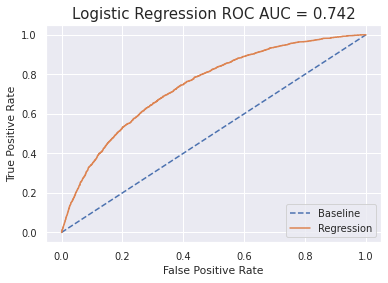

In [44]:
fpr, tpr, threshold = roc_curve(y_valid, y_pred_proba)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc).set_fontsize(15)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

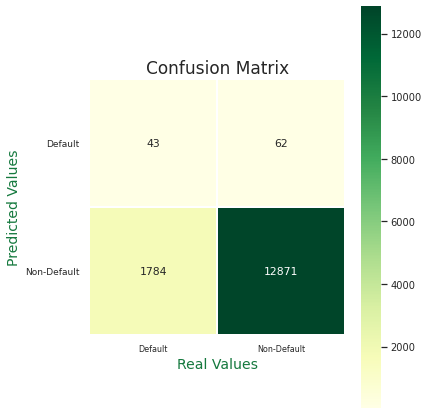

In [47]:
# Расчёт Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
cm[0,0], cm[1,1] = cm[1,1], cm[0,0]

class_names = ['Default', 'Non-Default']
color_text = plt.get_cmap('YlGn')(0.8)

data = pd.DataFrame(cm, index=class_names, columns=class_names)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set(xticks=np.arange(cm.shape[1]), 
       yticks=np.arange(cm.shape[0]), 
       title="Confusion Matrix")
ax.title.set_fontsize(17)

sns.heatmap(data, square=True, annot=True, 
            fmt="d", linewidths=1, cmap="YlGn")

ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
ax.set_xlabel('Real Values', fontsize=14, color = color_text)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=9)

fig.tight_layout()
plt.show()

In [48]:
dict_metric = {}

P = np.sum(y_valid == 1)
N = np.sum(y_valid == 0)
TP = np.sum((y_valid == 1) & (y_pred == 1))
TN = np.sum((y_valid == 0) & (y_pred == 0))
FP = np.sum((y_valid == 0) & (y_pred == 1))
FN = np.sum((y_valid == 1) & (y_pred == 0))
    
dict_metric['Positive, P'] = [P,'default']
dict_metric['Negative, N'] = [N,'non-default']
dict_metric['True Positive, TP'] = [TP,'correctly identified default']
dict_metric['True Negative, TN'] = [TN,'correctly identified non-default']
dict_metric['False Positive, FP'] = [FP,'incorrectly identified default']
dict_metric['False Negative, FN'] = [FN,'incorrectly identified non-default']
dict_metric['Accuracy'] = [accuracy_score(y_valid, y_pred),'Accuracy = (TP+TN)/(P+N)']
dict_metric['Precision'] = [precision_score(y_valid, y_pred),'Precision = TP/(TP+FP)'] 
dict_metric['Recall'] = [recall_score(y_valid, y_pred),'Recall = TP/P']
dict_metric['F1-score'] = [f1_score(y_valid, y_pred),'Harmonical mean of Precision и Recall']
dict_metric['ROC_AUC'] = [roc_auc_score(y_valid, y_pred_proba),'ROC AUC Score']    

df_metr = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Value', 'Description'])
df_metr = df_metr.round(3)
display(df_metr)

,Value,Description
"Positive, P",1827.000,default
"Negative, N",12933.000,non-default
"True Positive, TP",43.000,correctly identified default
"True Negative, TN",12871.000,correctly identified non-default
"False Positive, FP",62.000,incorrectly identified default
"False Negative, FN",1784.000,incorrectly identified non-default
Accuracy,0.875,Accuracy = (TP+TN)/(P+N)
Precision,0.410,Precision = TP/(TP+FP)
Recall,0.024,Recall = TP/P
F1-score,0.045,Harmonical mean of Precision и Recall


**Вывод по модели:** 

Согласно матрицы ошибок, в модели высокая ошибка второго рода (FN > 13% TN). И критически низкий Recall ~2.4%. Показатель ROC-AUC при этом высокий, однако он вводит в заблуждение. 

### 10. Регуляризация

#### Подбор гиперпараметров для логистической регрессии

С помощью GridSearchCV

In [ ]:
# Добавим типы регуляризации
penalty = ['l1', 'l2', 'none']

# Зададим список значений для параметра регуляризации C
C = [(i/10) for i in range(1, 10)] + [i/1 for i in range(1, 21)]

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, max_iter=[700])

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, scoring='f1', cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)
best_parameters = best_model.best_estimator_.get_params()

for p in sorted(best_parameters.keys()):
    print('\t%s: %r' % (p, best_parameters[p]))

#### Обновим модель с учётом новых параметров

In [49]:
model = LogisticRegression(C=10, penalty='l2', max_iter = 700, solver='liblinear', 
                           class_weight='balanced', multi_class = 'ovr')

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_valid)[:,1]
y_pred = model.predict(X_valid)

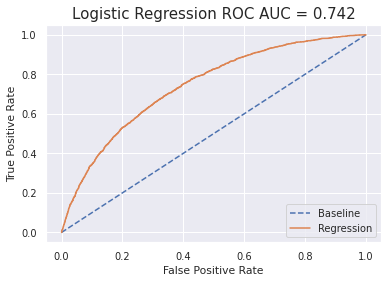

In [50]:
fpr, tpr, threshold = roc_curve(y_valid, y_pred_proba)
roc_auc = roc_auc_score(y_valid, y_pred_proba)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc).set_fontsize(15)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

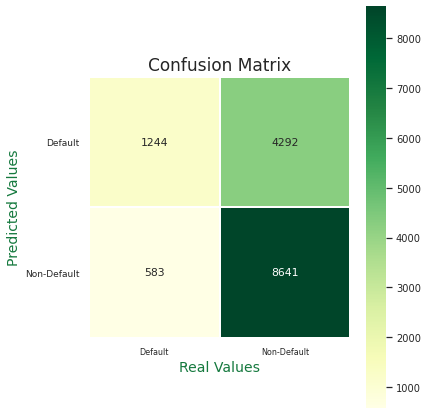

In [51]:
# Расчёт Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
cm[0,0], cm[1,1] = cm[1,1], cm[0,0]

class_names = ['Default', 'Non-Default']
color_text = plt.get_cmap('YlGn')(0.8)

data = pd.DataFrame(cm, index=class_names, columns=class_names)

fig, ax = plt.subplots(figsize=(6, 6))
ax.set(xticks=np.arange(cm.shape[1]), 
       yticks=np.arange(cm.shape[0]), 
       title="Confusion Matrix")
ax.title.set_fontsize(17)

sns.heatmap(data, square=True, annot=True, 
            fmt="d", linewidths=1, cmap="YlGn")

ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
ax.set_xlabel('Real Values', fontsize=14, color = color_text)
plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=8)
plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=9)

fig.tight_layout()
plt.show()

In [52]:
dict_metric = {}

P = np.sum(y_valid == 1)
N = np.sum(y_valid == 0)
TP = np.sum((y_valid == 1) & (y_pred == 1))
TN = np.sum((y_valid == 0) & (y_pred == 0))
FP = np.sum((y_valid == 0) & (y_pred == 1))
FN = np.sum((y_valid == 1) & (y_pred == 0))
    
dict_metric['Positive, P'] = [P,'default']
dict_metric['Negative, N'] = [N,'non-default']
dict_metric['True Positive, TP'] = [TP,'correctly identified default']
dict_metric['True Negative, TN'] = [TN,'correctly identified non-default']
dict_metric['False Positive, FP'] = [FP,'incorrectly identified default']
dict_metric['False Negative, FN'] = [FN,'incorrectly identified non-default']
dict_metric['Accuracy'] = [accuracy_score(y_valid, y_pred),'Accuracy = (TP+TN)/(P+N)']
dict_metric['Precision'] = [precision_score(y_valid, y_pred),'Precision = TP/(TP+FP)'] 
dict_metric['Recall'] = [recall_score(y_valid, y_pred),'Recall = TP/P']
dict_metric['F1-score'] = [f1_score(y_valid, y_pred),'Harmonical mean of Precision и Recall']
dict_metric['ROC_AUC'] = [roc_auc_score(y_valid, y_pred_proba),'ROC AUC Score']    

df_metr = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Value', 'Description'])
df_metr = df_metr.round(3)
display(df_metr)

,Value,Description
"Positive, P",1827.000,default
"Negative, N",12933.000,non-default
"True Positive, TP",1244.000,correctly identified default
"True Negative, TN",8641.000,correctly identified non-default
"False Positive, FP",4292.000,incorrectly identified default
"False Negative, FN",583.000,incorrectly identified non-default
Accuracy,0.670,Accuracy = (TP+TN)/(P+N)
Precision,0.225,Precision = TP/(TP+FP)
Recall,0.681,Recall = TP/P
F1-score,0.338,Harmonical mean of Precision и Recall


Удалось повысить F1 score - с 0.045 до 0.338. Однако, пришлось пожертвовать Precision модели. Что наиболее важно - повысилась точность определения дефолта (Recall вырос с 2.4% до 68%). Однако, в целом модель не очень уж точна и было бы полезно получить дополнительную информацию для скоринга. 

Малозначимые переменные: 
 home_address_3    0.000038
edu_nan           0.000087
dtype: float64


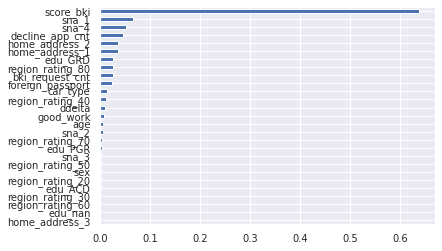

In [61]:
# Ещё раз проверим значимость признаков
importance = Series(mutual_info_classif(X_valid, y_pred,
                                        discrete_features=True), index=x_names)
importance.sort_values(inplace=True)
importance.plot(kind='barh');

print('Малозначимые переменные:\n', importance[importance.values < 0.0001])

### Submission

In [ ]:
X_test, y_test, f_names = x_processing(test_df, x_cat_cols, x_bin_cols, x_num_cols)

y_pred_proba = model.predict_proba(X_test)[:,1]

submission = pd.DataFrame(test_df['client_id'])
submission['default'] = y_pred_proba
submission.to_csv('submission.csv', index=False)
submission.sample(10)